In [1]:
from emoji import demojize
from instalooter.looters import HashtagLooter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import langid
import datetime

HASHTAG = '2019ncov'

# read data from file, disregard errors, and drop duplicates
df = pd.read_csv('{}.csv'.format(HASHTAG),error_bad_lines=False).drop_duplicates()


## loading the dataframe

In [2]:
def hashtags_in_str(r):
    '''given a string, returns an array containing 
    the number of hashtags used [0] and 
    a list of the used hashtags [1]'''
    word_list=[]
    tag_list=[]
    
    word_list = str(r).split()
    
    for tag in word_list:
        if tag.startswith("#"):
            tag=tag.split('.')[0]
            tag_list.append(tag.strip("#"))
    try:
        tag_list.remove('')
    except:
        pass
    return len(tag_list),(', '.join(tag_list))

def language_id(text):
    return str(langid.classify(text)[0])


# add hashtags as seperate cols
df['num_of_hashtags'], df['hashtags'] = zip(*df['edge_media_to_caption'].map(hashtags_in_str))

# add detected language as col
df['detected_language'] = df.apply(lambda row: language_id(row.edge_media_to_caption), axis = 1) 

# convert UNIX timestamp to datetime-timestamp
df['timestamp'] = pd.to_datetime(df['taken_at_timestamp'], unit='s')

#just the date
df['just_date'] = df['timestamp'].dt.date

# remove rows where there are no hashtags
df = df[df.num_of_hashtags != 0]

# remove rows which are not "english"
df = df[df.detected_language == 'en']

# remove id duplicates
df = df.drop_duplicates(subset='id',keep='first')


## checking the dataframe

In [3]:
print('Average number of hashtags used per caption: {}'.format(round(df['num_of_hashtags'].mean(),2)))

df[['num_of_hashtags']].describe()


Average number of hashtags used per caption: 8.71


,num_of_hashtags
count,2363.000000
mean,8.713500
std,7.938242
min,1.000000
25%,3.000000
50%,6.000000
75%,12.000000
max,32.000000


## Plotting comments per post over time

c:\users\jan\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


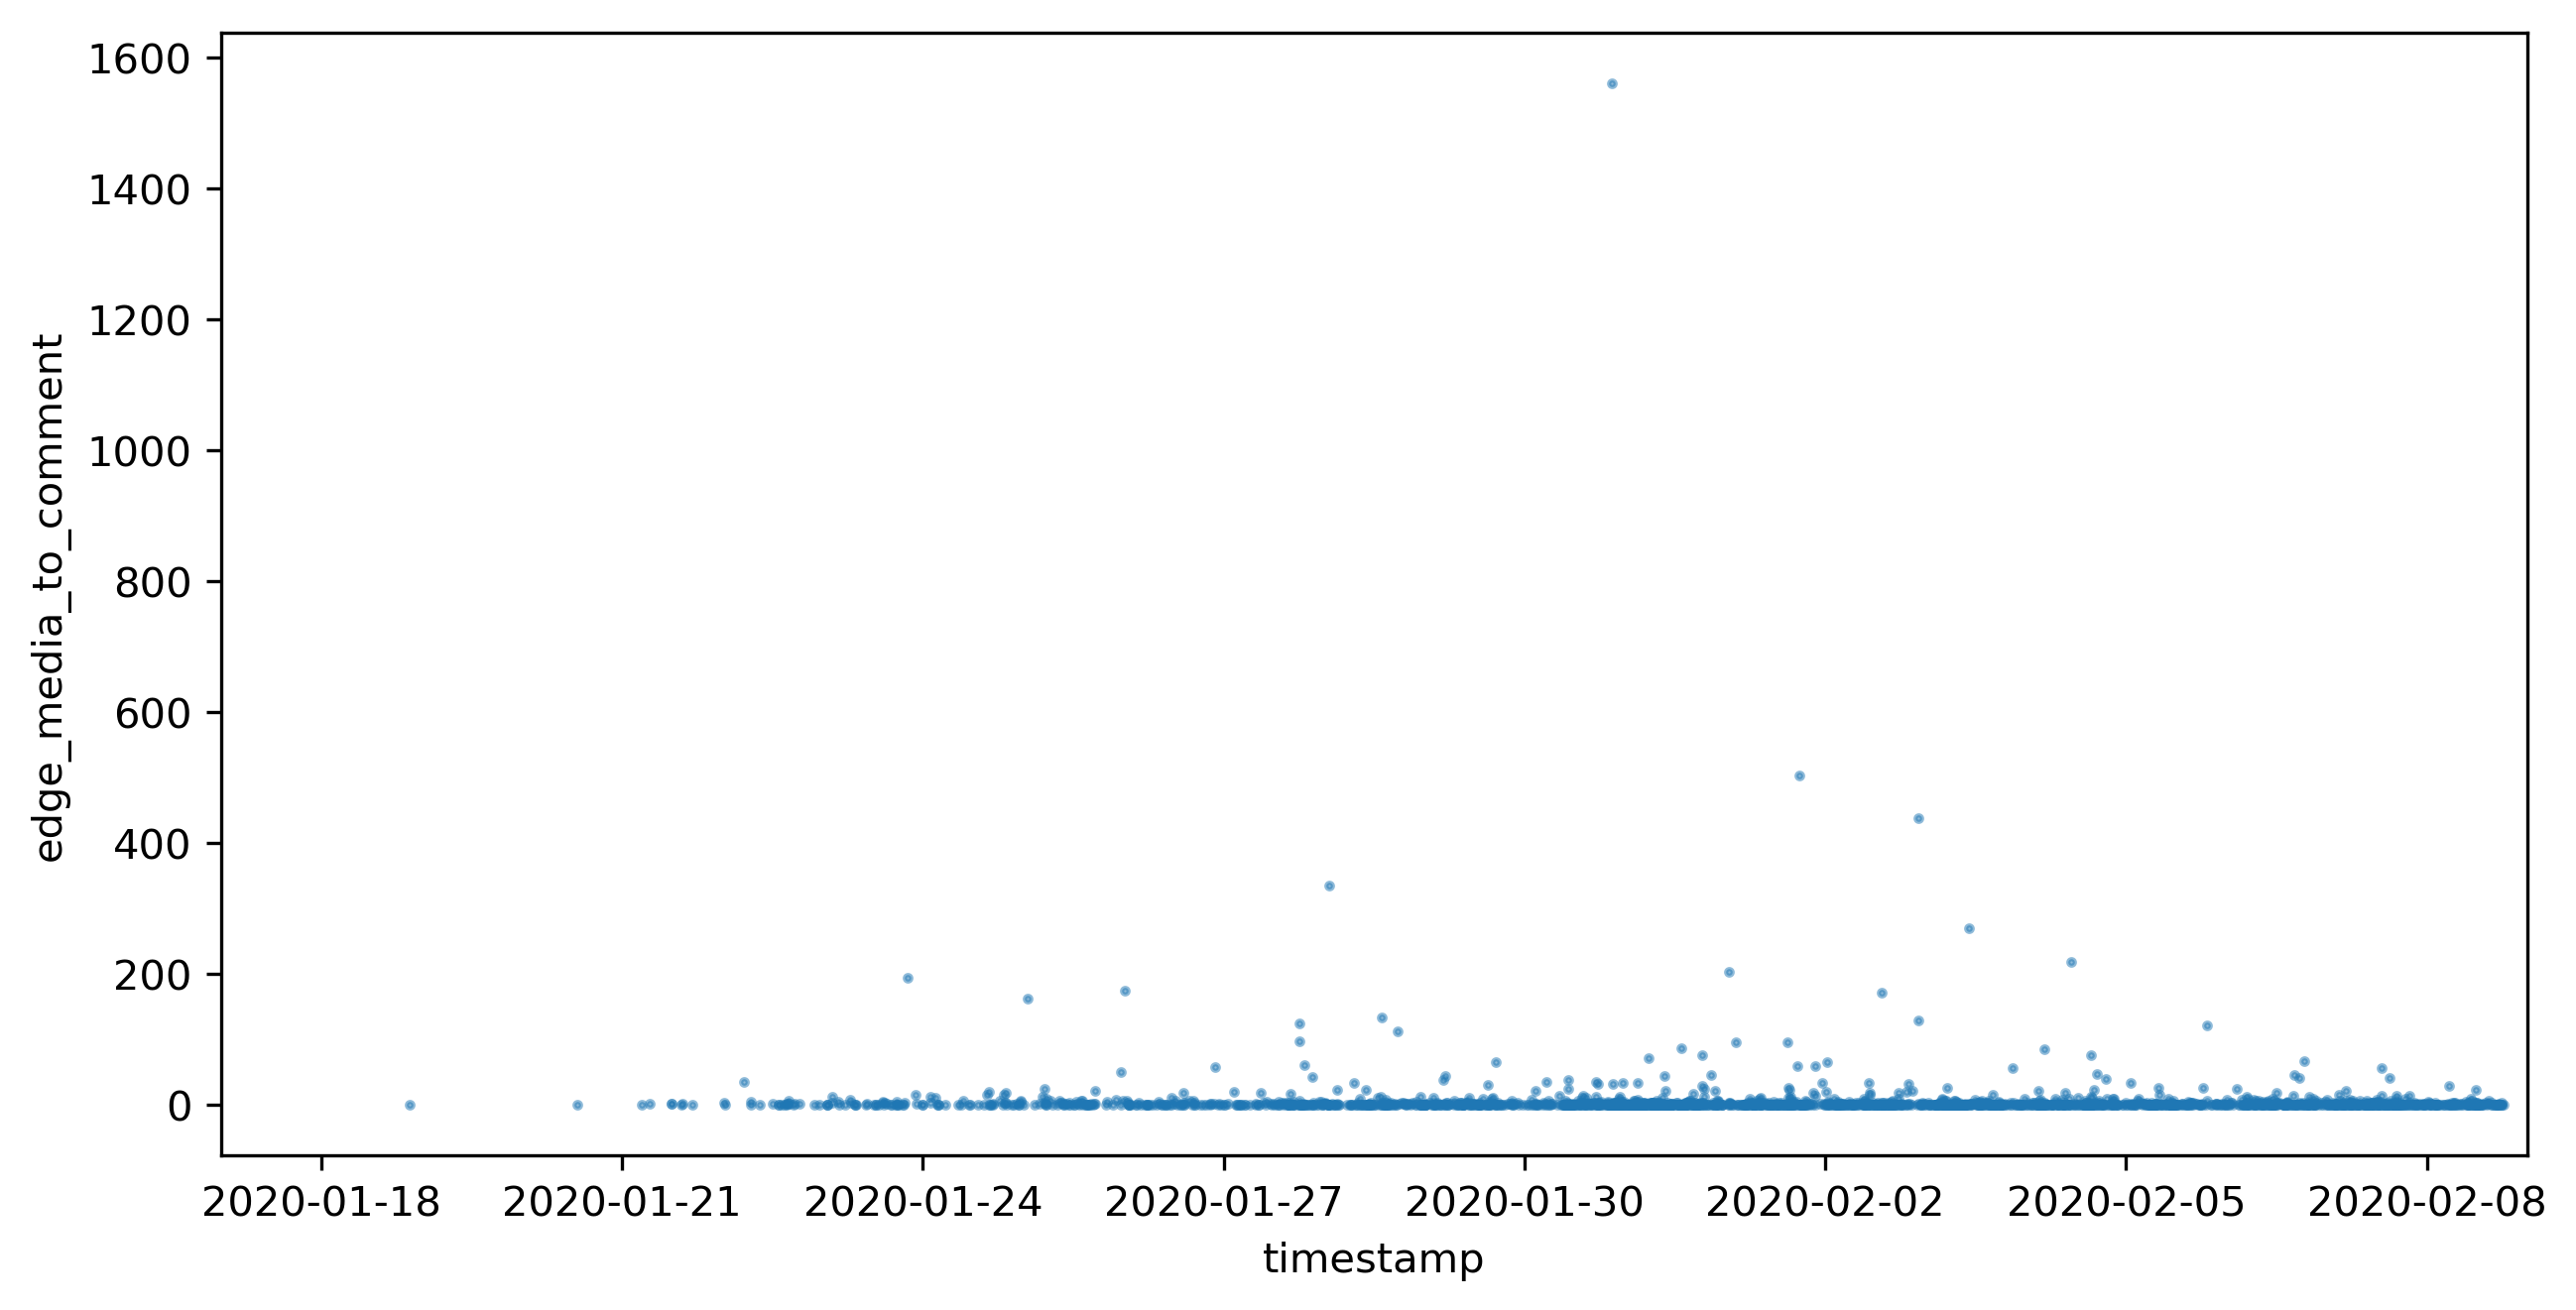

In [4]:
%matplotlib inline
num1 = -1

y_axis='edge_media_to_comment'
x_axis='timestamp'

plt.figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.scatter(x = df[:num1][x_axis],y = df[:num1][y_axis],
           marker='.',
            s=10,
            alpha=0.5)

plt.xlabel(x_axis) 
plt.ylabel(y_axis)

plt.xlim([datetime.date(2020, 1, 17), datetime.date(2020, 2, 9)])
plt.show()



## Checking the comment outlier

In [5]:
alt_df = df

#alt_df = alt_df.style.set_properties(**{'word-wrap': 'break-word'})
alt_df = alt_df.sort_values(by='edge_media_to_comment',ascending=False)
alt_df.head(3)[['id','timestamp','hashtags','edge_media_to_caption','edge_media_to_comment']]

,id,timestamp,hashtags,edge_media_to_caption,edge_media_to_comment
5658,2233027292255687416,2020-01-30 20:53:38,2019nCoV,@drtedros declared a public health emergency o...,1560
4145,2234384823137756723,2020-02-01 17:50:49,"2019nCoV, MythBusting",Here are some facts about the #2019nCoV #MythB...,502
3430,2235246377177676962,2020-02-02 22:22:34,"2019nCoV, MythBusting, KnowTheFacts",Here are some facts about the #2019nCoV #MythB...,438


The comments outlier is [this](https://www.instagram.com/p/B79Tn3ApxL4/?hl=de) posting by the World Health Organization's Instagram account.

In [6]:
#errors checks

# cannot be more than one count per entry
#df['id'].value_counts().head(5)

## preparing the data for plotting

In [7]:
tag_dict ={}

for hashtags in df['hashtags']:
    for tags in [hashtags]:
        for tag in tags.split(', '):
            tag= tag.lower()
            if tag in tag_dict.keys():
                tag_dict[tag] += 1
            else:
                tag_dict[tag] = 1


# cut off limit for mentions for hashtags
occurences = 50

# empty list of the hashtags to delete from the dictionary
small_num_hashtags =[]


for key in tag_dict.keys():
    if tag_dict[key] <=occurences:
        small_num_hashtags.append(key)

#delete hashtags that did not make the cut as defined by the occurences variable 
for useless_hashtag in small_num_hashtags:
    try:
        tag_dict.pop(useless_hashtag,None)
    except KeyError:
        pass

## Plotting Hashtag Usage

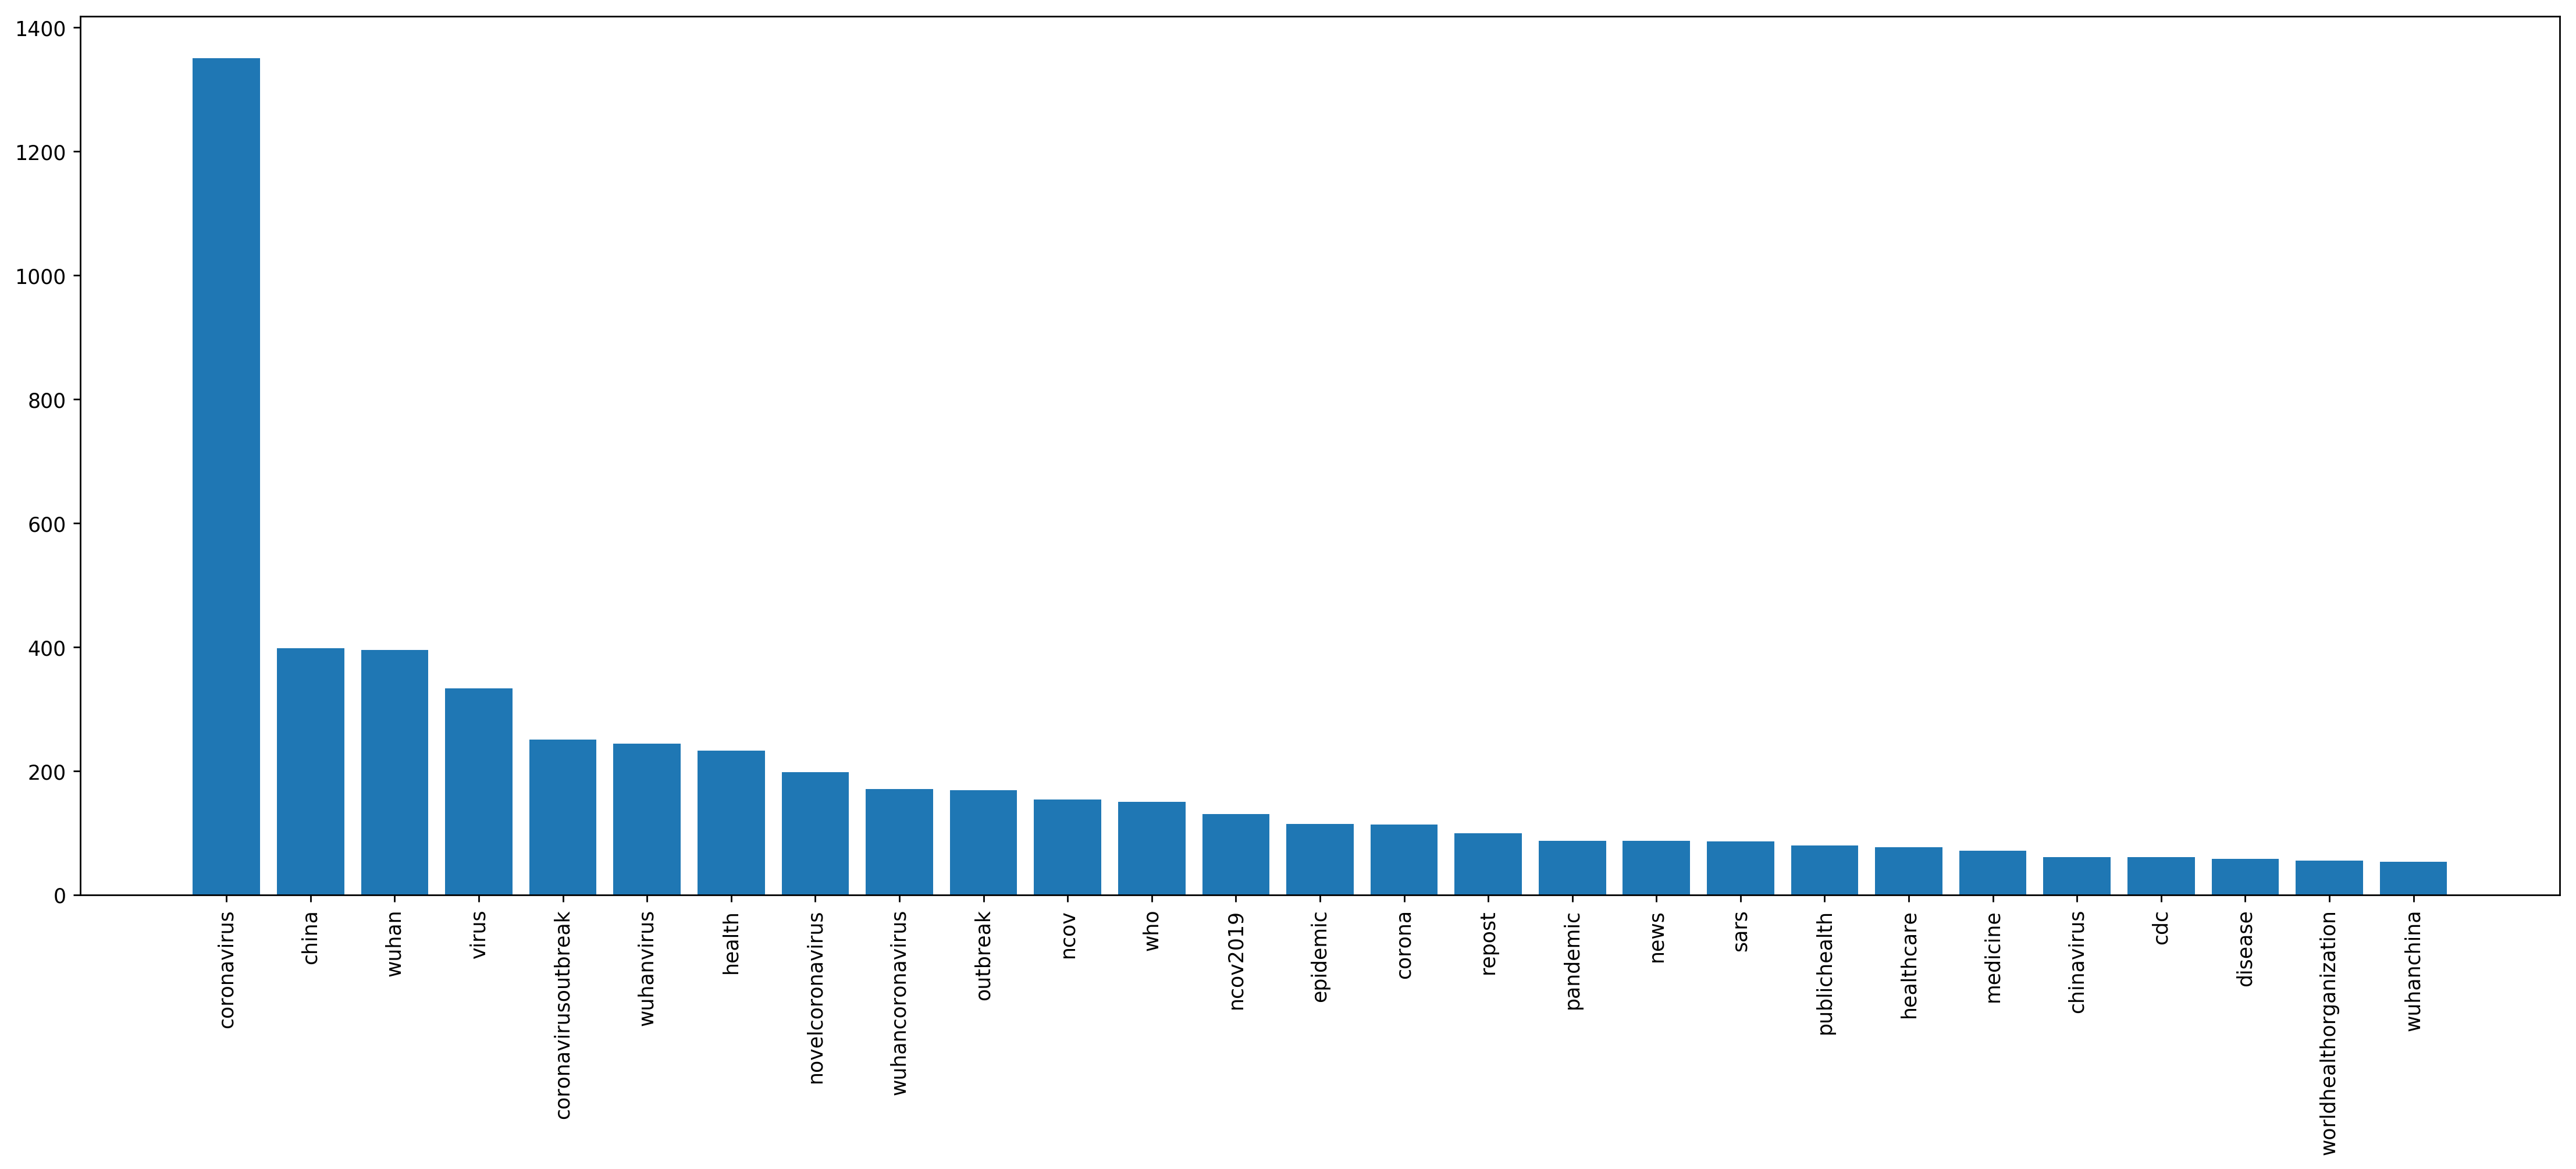

In [8]:
# delete the hashtag used for searching from the dict
tag_dict.pop(HASHTAG,None)

D = {k: v for k, v in sorted(tag_dict.items(), key=lambda item: item[1],reverse=True)}

plt.figure(num=None, figsize=(22, 8), dpi=250, facecolor='w', edgecolor='k')

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()),rotation=90)

plt.show()

In [9]:
D = {k: v for k, v in sorted(tag_dict.items(), key=lambda item: item[1],reverse=True)}

hashtag_df = pd.DataFrame(list(D.items()),columns = ['hashtag','mentions'])

hashtag_df['percent'] = round(hashtag_df['mentions']/int(len(df['num_of_hashtags'])),4)

# read the dataframe results as: 
print("The hashtag #{} was mentioned with the hashtag #{} in {}% off all captions.".format(HASHTAG,hashtag_df['hashtag'][0],round(100*(hashtag_df['percent'][0]),2)))

#Top 25 List
hashtag_df[:25]


The hashtag #2019ncov was mentioned with the hashtag #coronavirus in 57.17% off all captions.


,hashtag,mentions,percent
0,coronavirus,1351,0.5717
1,china,398,0.1684
2,wuhan,395,0.1672
3,virus,333,0.1409
4,coronavirusoutbreak,251,0.1062
5,wuhanvirus,244,0.1033
6,health,233,0.0986
7,novelcoronavirus,198,0.0838
8,wuhancoronavirus,171,0.0724
9,outbreak,169,0.0715


## postings per day

In [10]:
day_dict ={}

for day in df['just_date']:
    if day in day_dict.keys():
        day_dict[day] += 1
    else:
        day_dict[day] = 1
                
DAYS = {k: v for k, v in sorted(day_dict.items(), key=lambda item: item[1],reverse=True)}


DAYS.pop(datetime.date(2018, 11, 22),None)
DAYS.pop(datetime.date(2017, 10, 12),None)
DAYS.pop(datetime.date(2019, 7, 17),None)
DAYS.pop(datetime.date(2017, 10, 12),None)
DAYS.pop(datetime.date(2019, 9, 27),None)
DAYS.pop(datetime.date(2019, 10, 29),None)
DAYS.pop(datetime.date(2019, 10, 18),None)
DAYS.pop(datetime.date(2019, 12, 1),None)
DAYS.pop(datetime.date(2019, 10, 23),None)
DAYS.pop(datetime.date(2019, 10, 2),None)
DAYS.pop(datetime.date(2019, 10, 19),None)
DAYS.pop(datetime.date(2019, 10, 21),None)
DAYS.pop(datetime.date(2019, 7, 15),None)

1

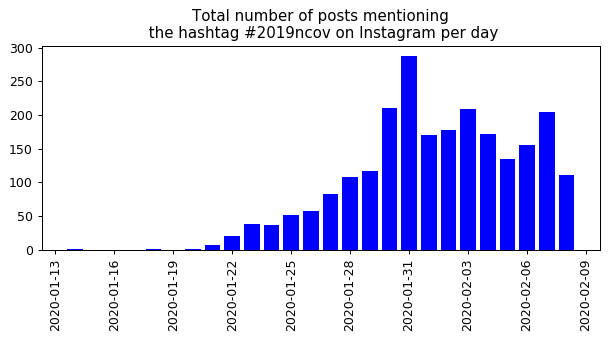

In [16]:
plt.figure(num=None, figsize=(8, 3), dpi=90, facecolor='w', edgecolor='k')
plt.xticks(rotation=90)
plt.bar(DAYS.keys(), DAYS.values(),  color='b')
plt.title('Total number of posts mentioning\n the hashtag #{} on Instagram per day'.format(HASHTAG))
plt.show()